# OpenStreetMaps
1. Overview
2. Query data
3. Routing/accessibility

In [161]:
# https://geopandas.org/en/stable/getting_started/install.html
# conda create -n ox -c conda-forge --strict-channel-priority osmnx jupyterlab pandas geopandas gadm

In [162]:
# https://pygis.io/docs/d_access_osm.html
# https://geoffboeing.com/2016/11/osmnx-python-street-networks/

## Setup

In [305]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import h3
from shapely.geometry import Polygon
import os

from gadm import GADMDownloader
downloader = GADMDownloader(version="4.0")

## Load Graph

### Load using name

In [164]:
# Load graph. If doesn't exist on disk, downloads and saves. 
if os.path.exists('~/Desktop/lagos_street_graph.graphml'):
    G = ox.load_graphml('~/Desktop/lagos_street_graph.graphml')
else:
    G = ox.graph_from_place('Lagos, Nigeria', network_type='drive')
    ox.save_graphml(G, '~/Desktop/lagos_street_graph.graphml')

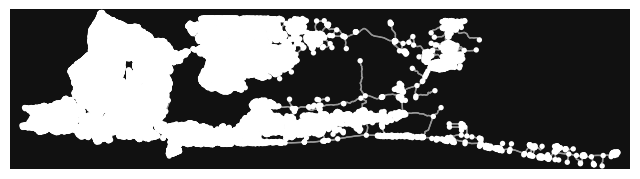

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [165]:
ox.plot_graph(G)

### Load using geodataframe

In [166]:
nga_gdf = downloader.get_shape_data_by_country_name(country_name="Nigeria", ad_level=2)
ikeja_gdf = nga_gdf[nga_gdf.NAME_2 == "Ikeja"]

<Axes: >

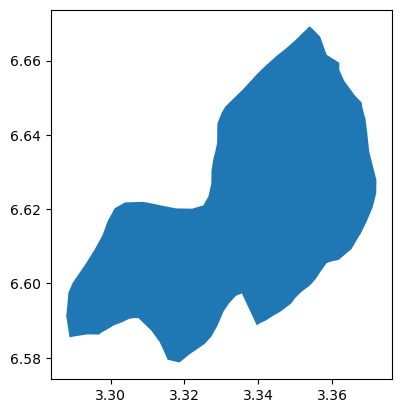

In [167]:
ikeja_gdf.plot()

In [168]:
G_ikeja = ox.graph_from_polygon(ikeja_gdf.geometry.iloc[0], network_type='drive')

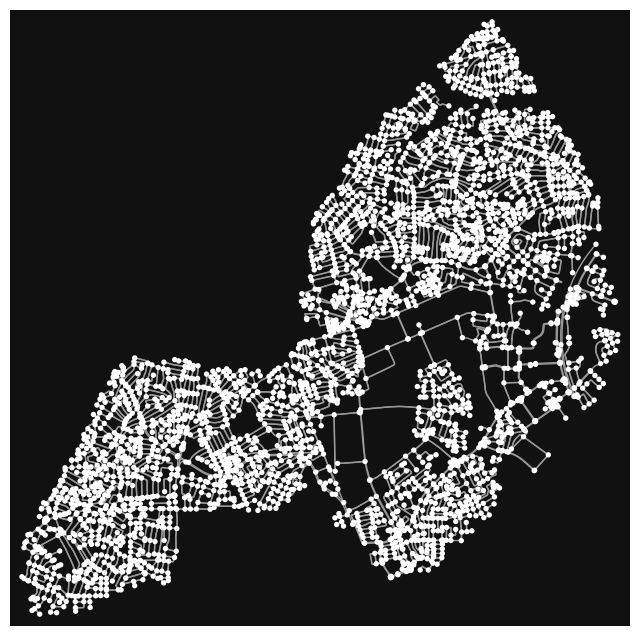

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [169]:
ox.plot_graph(G_ikeja)

## Routing

In [170]:
# Add edge speeds and travel times
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [171]:
# Define orgin/destination
lamata_node      = ox.nearest_nodes(G, 3.3832, 6.5944) # long, lat
yabacollege_node = ox.nearest_nodes(G, 3.3720, 6.5192) # long, lat 

In [172]:
# Route that minimizes travel time
route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time') # Could also be: "length"

In [173]:
# Route is just a list of edge IDs
route[:5]

[1473223187, 1473223406, 1473223305, 5616502226, 5606072169]

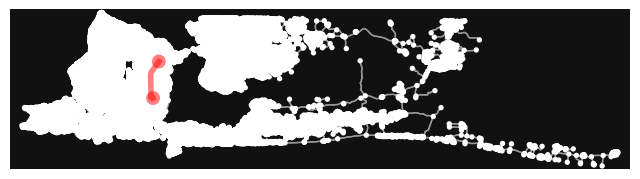

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [174]:
# Plot the route
ox.plot_graph_route(G, route)

In [175]:
# Convert route to geopandas dataframe
route_gdf = ox.routing.route_to_gdf(G, route)

In [176]:
# View
route_gdf.head()

,,,osmid,oneway,lanes,ref,name,highway,reversed,length,geometry,speed_kph,travel_time,tunnel,junction,bridge
u,v,key,,,,,,,,,,,,,,
1473223187,1473223406,0,133882114,True,NaN,NaN,NaN,primary,False,203.207,"LINESTRING (3.38366 6.59466, 3.38338 6.59424, ...",74.0,9.9,NaN,NaN,NaN
1473223406,1473223305,0,133882114,True,NaN,NaN,NaN,primary,False,329.424,"LINESTRING (3.38261 6.59316, 3.38102 6.59099, ...",74.0,16.0,NaN,NaN,NaN
1473223305,5616502226,0,133882114,True,NaN,NaN,NaN,primary,False,22.086,"LINESTRING (3.38083 6.59078, 3.38071 6.59063)",74.0,1.1,NaN,NaN,NaN
5616502226,5606072169,0,133882114,True,NaN,NaN,NaN,primary,False,157.684,"LINESTRING (3.38071 6.59063, 3.38062 6.59050, ...",74.0,7.7,NaN,NaN,NaN
5606072169,6291361181,0,586759385,True,NaN,NaN,NaN,motorway_link,False,22.441,"LINESTRING (3.37989 6.58946, 3.37983 6.58927)",80.0,1.0,NaN,NaN,NaN


In [78]:
# Length in meters
distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance, 'meters')
print('Total travel time:', travel_time, 'seconds')

Total distance: 9741.146 meters
Total travel time: 467.7 seconds


In [79]:
# Make an interactive map
route_gdf.explore()

## Route based on different road network

#### 1. Change graph

In [177]:
# Convert to geopandas
G_gdf = ox.convert.graph_to_gdfs(G)

In [178]:
# Tupple of length 2
# (nodes, edges)
len(G_gdf)

2

In [179]:
G_nodes_gdf = G_gdf[0]
G_edges_gdf = G_gdf[1]

In [180]:
ik_road = G_edges_gdf[G_edges_gdf.name == "Ikorodu Road"]
ik_road.explore()

In [186]:
# Set road closure
G_edges_gdf.loc[G_edges_gdf['name'] == "Ikorodu Road", 'travel_time'] = 99999999

In [190]:
G_closure = ox.convert.graph_from_gdfs(gdf_nodes = G_nodes_gdf,
                                       gdf_edges = G_edges_gdf)

#### Route using new graph

In [198]:
# Original

route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')

route_gdf = ox.routing.route_to_gdf(G, route)

distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance / 1000, 'kilometers')
print('Total travel time:', travel_time / 60, 'minutes')

Total distance: 9.742187999999999 kilometers
Total travel time: 7.711666666666667 minutes


In [199]:
# Graph with Ikodoru Route Closed

route = ox.shortest_path(G_closure, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')

route_gdf = ox.routing.route_to_gdf(G, route)

distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance / 1000, 'kilometers')
print('Total travel time:', travel_time / 60, 'minutes')

Total distance: 11.940184999999998 kilometers
Total travel time: 11.54 minutes


In [200]:
route_gdf.explore()

## Network Statistics

### Betweenness Centrality
1. Between each node, compute the shortest path
2. Determine the number (proportion) of shortest paths that pass through each node

In [202]:
bc = nx.betweenness_centrality(G_ikeja)

In [203]:
# The node with the highest betweenness centrality
# 41% of shortest paths go through this node
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(7324468009, 0.41114816334499804)

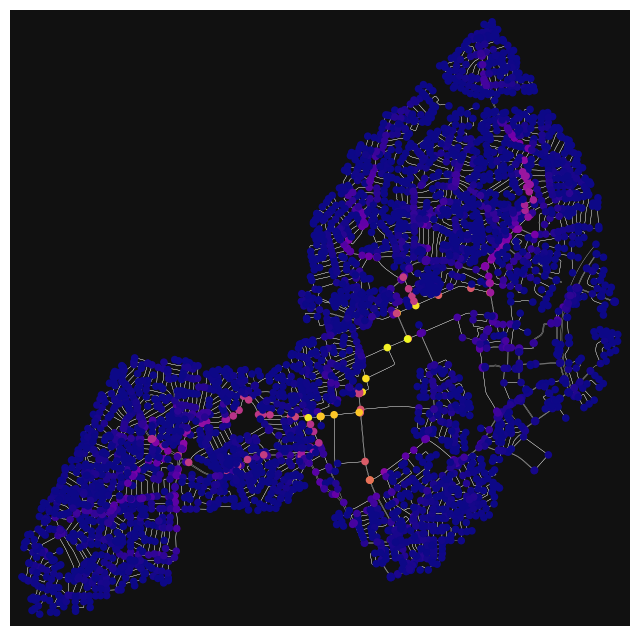

In [205]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G_ikeja, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G_ikeja, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G_ikeja,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

## Query Points of Interest

Query [bus stops](https://www.openstreetmap.org/node/6967079716)

In [211]:
bus_gdf = ox.features.features_from_place(query = "Lagos, Nigeria",
                                tags = {'highway': 'bus_stop',
                                       'amenity': 'bus_station'})

In [213]:
bus_gdf.shape

(158, 30)

In [214]:
bus_gdf.head()

highway     name                 geometry  bus  \
element_type osmid                                                         
node         3095002640  bus_stop  Chevron  POINT (3.52971 6.44103)  NaN   
             3095002719  bus_stop  Chevron  POINT (3.53202 6.44171)  NaN   
             5194462808  bus_stop  Chevron  POINT (3.52983 6.44072)  NaN   
             5194462809  bus_stop  Chevron  POINT (3.53191 6.44192)  NaN   
             5246332118  bus_stop      NaN  POINT (3.61753 6.47508)  yes   

                        public_transport addr:country operator shelter note  \
element_type osmid                                                            
node         3095002640              NaN          NaN      NaN     NaN  NaN   
             3095002719              NaN          NaN      NaN     NaN  NaN   
             5194462808              NaN          NaN      NaN     NaN  NaN   
             5194462809              NaN          NaN      NaN     NaN  NaN   
             5246332118         platform          NaN      NaN     NaN  NaN   

                        amenity  ... departures_board foot motor_vehicle  \
element_type osmid               ...                                       
node         3095002640     NaN  ...              NaN  NaN           NaN   
             3095002719     NaN  ...              NaN  NaN           NaN   
             5194462808     NaN  ...              NaN  NaN           NaN   
             5194462809     NaN  ...              NaN  NaN           NaN   
             5246332118     NaN  ...              NaN  NaN           NaN   

                        surface bus_stop:category building building:levels  \
element_type osmid                                                           
node         3095002640     NaN               NaN      NaN             NaN   
             3095002719     NaN               NaN      NaN             NaN   
             5194462808     NaN               NaN      NaN             NaN   
             5194462809     NaN               NaN      NaN             NaN   
             5246332118     NaN               NaN      NaN             NaN   

                        description wikidata wikipedia  
element_type osmid                                      
node         3095002640         NaN      NaN       NaN  
             3095002719         NaN      NaN       NaN  
             5194462808         NaN      NaN       NaN  
             5194462809         NaN      NaN       NaN  
             5246332118         NaN      NaN       NaN  

[5 rows x 30 columns]

In [215]:
bus_gdf.explore()

## Accessibility to bus stops

### 1. Add nearest node to bus stops

In [ ]:
def det_nearest_node(row):
    n_node = ox.nearest_nodes(G, row['longitude'], row['latitude'])
    return(n_node)

In [367]:
bus_gdf['centroid'] = bus_gdf.centroid

bus_gdf['longitude'] = bus_gdf['centroid'].x
bus_gdf['latitude'] = bus_gdf['centroid'].y

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_94963/387089161.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bus_gdf['centroid'] = bus_gdf.centroid


In [385]:
bus_gdf['node'] = bus_gdf.apply(det_nearest_node, axis=1)

In [386]:
bus_gdf.head()

highway     name                 geometry  bus  \
element_type osmid                                                         
node         3095002640  bus_stop  Chevron  POINT (3.52971 6.44103)  NaN   
             3095002719  bus_stop  Chevron  POINT (3.53202 6.44171)  NaN   
             5194462808  bus_stop  Chevron  POINT (3.52983 6.44072)  NaN   
             5194462809  bus_stop  Chevron  POINT (3.53191 6.44192)  NaN   
             5246332118  bus_stop      NaN  POINT (3.61753 6.47508)  yes   

                        public_transport addr:country operator shelter note  \
element_type osmid                                                            
node         3095002640              NaN          NaN      NaN     NaN  NaN   
             3095002719              NaN          NaN      NaN     NaN  NaN   
             5194462808              NaN          NaN      NaN     NaN  NaN   
             5194462809              NaN          NaN      NaN     NaN  NaN   
             5246332118         platform          NaN      NaN     NaN  NaN   

                        amenity  ... bus_stop:category building  \
element_type osmid               ...                              
node         3095002640     NaN  ...               NaN      NaN   
             3095002719     NaN  ...               NaN      NaN   
             5194462808     NaN  ...               NaN      NaN   
             5194462809     NaN  ...               NaN      NaN   
             5246332118     NaN  ...               NaN      NaN   

                        building:levels description wikidata wikipedia  \
element_type osmid                                                       
node         3095002640             NaN         NaN      NaN       NaN   
             3095002719             NaN         NaN      NaN       NaN   
             5194462808             NaN         NaN      NaN       NaN   
             5194462809             NaN         NaN      NaN       NaN   
             5246332118             NaN         NaN      NaN       NaN   

                                        centroid longitude  latitude  \
element_type osmid                                                     
node         3095002640  POINT (3.52971 6.44103)  3.529713  6.441032   
             3095002719  POINT (3.53202 6.44171)  3.532017  6.441715   
             5194462808  POINT (3.52983 6.44072)  3.529829  6.440718   
             5194462809  POINT (3.53191 6.44192)  3.531910  6.441922   
             5246332118  POINT (3.61753 6.47508)  3.617531  6.475082   

                               node  
element_type osmid                   
node         3095002640  5184438466  
             3095002719  1832697416  
             5194462808  5184438466  
             5194462809  1832697416  
             5246332118  5246332118  

[5 rows x 34 columns]

### 2. Make hexagons that cover Lagos

We'll determine accessibility from each hexagon to bus stops

In [387]:
nga_gdf = downloader.get_shape_data_by_country_name(country_name="Nigeria", ad_level=1)
lagos_gdf = nga_gdf[nga_gdf.NAME_1 == "Lagos"]

In [388]:
# Convert from multipolygon to polygon
lagos_gdf = lagos_gdf.explode()

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_94963/4189579028.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lagos_gdf = lagos_gdf.explode()


In [389]:
lagos_hexagons = h3.polyfill(lagos_gdf.geometry.iloc[0].__geo_interface__, 7)

In [390]:
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id))

all_polys = gpd.GeoSeries(list(map(polygonise, lagos_hexagons)), \
                                      index=lagos_hexagons, \
                                      crs="EPSG:4326" \
                                     )

lagos_hex_gdf = gpd.GeoDataFrame(geometry=all_polys)

In [391]:
lagos_hex_gdf.explore()

### 3. Add node for each hexagon

In [392]:
lagos_hex_gdf['centroid'] = lagos_hex_gdf.centroid

lagos_hex_gdf['longitude'] = lagos_hex_gdf['centroid'].x
lagos_hex_gdf['latitude'] = lagos_hex_gdf['centroid'].y

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_94963/2753656803.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lagos_hex_gdf['centroid'] = lagos_hex_gdf.centroid


In [393]:
lagos_hex_gdf['node'] = lagos_hex_gdf.apply(det_nearest_node, axis=1)

### 4. Determine travel time from each hexagon to nearest bus station

For each hexagon, one approach would be to determine the travel time to all bus stations and take the minimum travel time. However, doing this for all hexagons would take a long time.

We know that bus stations very far away (straight line distance) also have long travel times. Consequently, we find the 10 closest (straight line distance) bus stops and calculate the travel time to each of those---and take the minimum value.

In [437]:
import geopy.distance

In [438]:
hex_i = lagos_hex_gdf.iloc[[0]]

In [445]:
bus_gdf['dist_to_hex_i'] = bus_gdf.geometry.apply(lambda g: hex_i.distance(g))

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_94963/3170236372.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bus_gdf['dist_to_hex_i'] = bus_gdf.geometry.apply(lambda g: hex_i.distance(g))


In [444]:
# 1. Arrange
# 2. Take top 10
# 3. Route
# 4. Minimum value

# -> put all in function
# -> apply function across hexagons

highway     name                 geometry  bus  \
element_type osmid                                                         
node         3095002640  bus_stop  Chevron  POINT (3.52971 6.44103)  NaN   
             3095002719  bus_stop  Chevron  POINT (3.53202 6.44171)  NaN   
             5194462808  bus_stop  Chevron  POINT (3.52983 6.44072)  NaN   
             5194462809  bus_stop  Chevron  POINT (3.53191 6.44192)  NaN   
             5246332118  bus_stop      NaN  POINT (3.61753 6.47508)  yes   

                        public_transport addr:country operator shelter note  \
element_type osmid                                                            
node         3095002640              NaN          NaN      NaN     NaN  NaN   
             3095002719              NaN          NaN      NaN     NaN  NaN   
             5194462808              NaN          NaN      NaN     NaN  NaN   
             5194462809              NaN          NaN      NaN     NaN  NaN   
             5246332118         platform          NaN      NaN     NaN  NaN   

                        amenity  ... building building:levels description  \
element_type osmid               ...                                        
node         3095002640     NaN  ...      NaN             NaN         NaN   
             3095002719     NaN  ...      NaN             NaN         NaN   
             5194462808     NaN  ...      NaN             NaN         NaN   
             5194462809     NaN  ...      NaN             NaN         NaN   
             5246332118     NaN  ...      NaN             NaN         NaN   

                        wikidata wikipedia                 centroid longitude  \
element_type osmid                                                              
node         3095002640      NaN       NaN  POINT (3.52971 6.44103)  3.529713   
             3095002719      NaN       NaN  POINT (3.53202 6.44171)  3.532017   
             5194462808      NaN       NaN  POINT (3.52983 6.44072)  3.529829   
             5194462809      NaN       NaN  POINT (3.53191 6.44192)  3.531910   
             5246332118      NaN       NaN  POINT (3.61753 6.47508)  3.617531   

                         latitude        node       dis  
element_type osmid                                       
node         3095002640  6.441032  5184438466  0.573807  
             3095002719  6.441715  1832697416  0.576126  
             5194462808  6.440718  5184438466  0.573915  
             5194462809  6.441922  1832697416  0.576025  
             5246332118  6.475082  5246332118  0.663193  

[5 rows x 35 columns]